<a href="https://colab.research.google.com/github/chanduadabala1/Machine_learning/blob/main/Monte_Carlo_Simulation_for_Portfolio_Returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-239668939.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-01-01", end="2024-01-01")
[*********************100%***********************]  2 of 2 completed


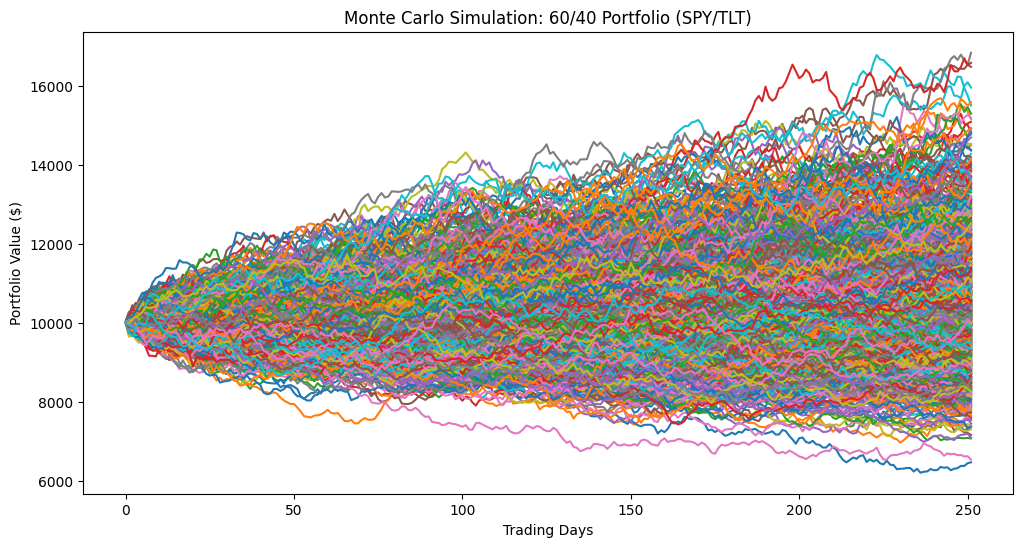

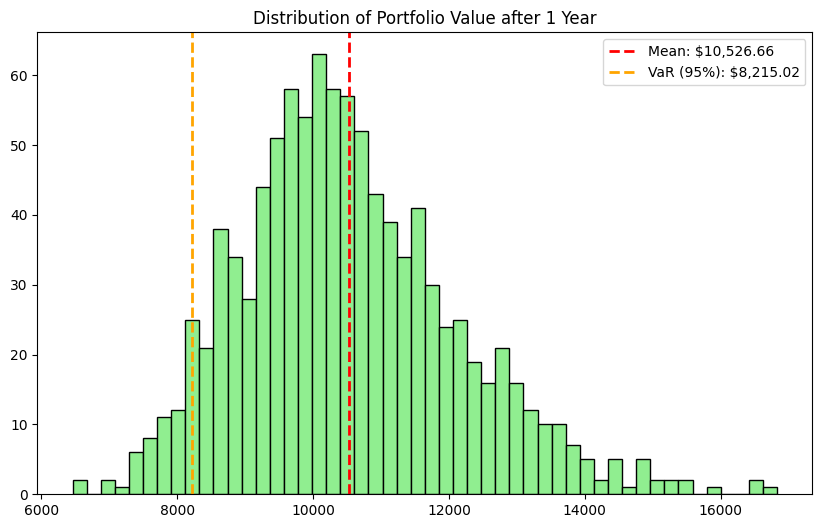

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# --- Step 1: Configuration ---
tickers = ['SPY', 'TLT']
weights = np.array([0.60, 0.40]) # Portfolio weights
initial_investment = 10000
years = 1
days = 252 * years
simulations = 1000

# --- Step 2: Get Data & Statistics ---
data = yf.download(tickers, start="2020-01-01", end="2024-01-01")

# Extract only the 'Close' prices for the specified tickers.
# yfinance with auto_adjust=True (default) makes 'Close' the adjusted price.
adjusted_close_prices = data['Close']

# Calculate Daily Log Returns using only the adjusted close prices
log_returns = np.log(1 + adjusted_close_prices.pct_change())

# Calculate Key Metrics
mean_returns = log_returns.mean().to_numpy()
std_devs = log_returns.std().to_numpy()
corr_matrix = log_returns.corr().to_numpy() # Correlation Matrix

# --- Step 3: The Cholesky Engine ---
# Calculate the Cholesky Decomposition of the Correlation Matrix
# This gives us the "structure" to link our random variables
L = np.linalg.cholesky(corr_matrix)

# --- Step 4: Run the Simulation ---
# Storage for the final portfolio value of each simulation
portfolio_sims = np.full((days, simulations), 0.0)

# We simulate the portfolio 'simulations' times
for m in range(simulations):
    # 1. Generate uncorrelated random noise for all assets over all days
    # Shape: (days, number of assets)
    Z_uncorrelated = np.random.normal(0, 1, (days, len(tickers)))

    # 2. Correlate the noise using the Cholesky matrix
    # We transpose Z to align shapes for dot product: (assets, days)
    Z_correlated = np.dot(L, Z_uncorrelated.T).T

    # 3. Reconstruct Asset Paths (GBM)
    # We need to track the price path of EACH asset separately first
    current_prices = adjusted_close_prices.iloc[-1].to_numpy()
    asset_paths = np.zeros((days, len(tickers)))
    asset_paths[0] = current_prices

    for t in range(1, days):
        # GBM Formula: S_t = S_{t-1} * exp(drift + diffusion)
        drift = mean_returns - 0.5 * std_devs**2
        diffusion = std_devs * Z_correlated[t]

        asset_paths[t] = asset_paths[t-1] * np.exp(drift + diffusion)

    # 4. Calculate Portfolio Value for this specific simulation path
    # Portfolio Value = Sum of (Price * Shares)
    # We assume we bought 'shares' at the start based on weights
    initial_prices = asset_paths[0]
    shares = (initial_investment * weights) / initial_prices

    # Calculate daily total portfolio value for this path
    portfolio_sims[:, m] = np.dot(asset_paths, shares)

# --- Step 5: Visualizing the Results ---
plt.figure(figsize=(12, 6))
plt.plot(portfolio_sims)
plt.title("Monte Carlo Simulation: 60/40 Portfolio (SPY/TLT)")
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value ($)")
plt.show()

# Histogram of Final Values
final_values = portfolio_sims[-1, :]
plt.figure(figsize=(10, 6))
plt.hist(final_values, bins=50, color='lightgreen', edgecolor='black')
plt.axvline(np.mean(final_values), color='red', linestyle='dashed', linewidth=2, label=f"Mean: ${np.mean(final_values):,.2f}")
plt.axvline(np.percentile(final_values, 5), color='orange', linestyle='dashed', linewidth=2, label=f"VaR (95%): ${np.percentile(final_values, 5):,.2f}")
plt.title(f"Distribution of Portfolio Value after {years} Year")
plt.legend()
plt.show()